# pymofa tutorial 1

## Introduction

This notebook introduces the basic functionalities of pymofa, the python modeling framework to run and evaluate your models systematically

The last update happed on:

In [1]:
import datetime
print(datetime.datetime.now().date())

2017-10-25


It does not hurt to locally install pymofa on your system by executing

    &pip install -e .
    
at the pymofa root folder.

If you prefer not to and want to work with this notebook interactively, exectue

In [2]:
# cd ..

to be at the pymofa root.

Can be left out if `pymofa` is (locally) installed at your system.

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## A discrete predetor prey dummy model
First we need to create a dummy model. Let's use a discrete version of the famous predator prey model.


In [4]:
def predprey_model(prey_birth_rate, prey_mortality, 
                   predator_efficiency, predator_death_rate,
                   initial_prey, initial_predators,
                   time_length):
    """Discrete predetor prey model."""
    A = -1 * np.ones(time_length)
    B = -1 * np.ones(time_length)
    A[0] = initial_prey
    B[0] = initial_predators
    for t in range(1, time_length):
        A[t] = A[t-1] + prey_birth_rate * A[t-1] - prey_mortality * B[t-1]*A[t-1]
        B[t] = B[t-1] + predator_efficiency * B[t-1]*A[t-1] - predator_death_rate * B[t-1] +\
            0.02 * (0.5 - np.random.rand())
    return A, B

**Example usage**:

In [5]:
preys, predators = predprey_model(0.1, 0.1, 0.1, 0.01, 1.0, 1.0, 1000)

<IPython.core.display.Javascript object>


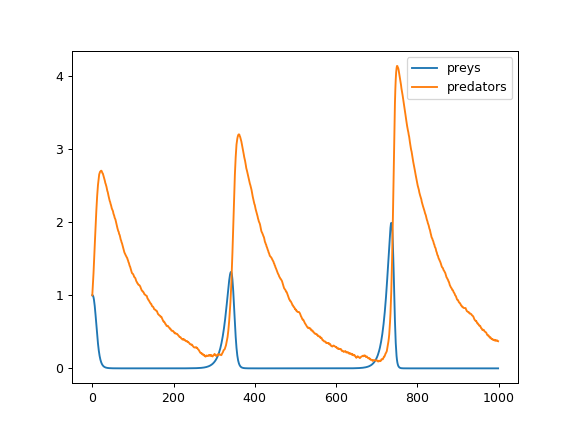

In [6]:
plt.plot(preys, label="preys") 
plt.plot(predators, label="predators")
plt.legend()

## Applying pymofa

In [7]:
# imports
from pymofa.experiment_handling import experiment_handling as eh
import itertools as it


In [8]:
# Path where to Store the simulated Data
SAVE_PATH_RAW = "./dummy/pmX01data"

In [9]:
# Definingh the experiment execution function
#      it gets paramater you want to investigate, plus `filename` as the last parameter
def RUN_FUNC(prey_birth_rate,
             coupling,
             predator_death_rate,
             initial_pop,
             time_length):  
    """Insightful docstring."""
    # poss. process
    prey_mortality = coupling
    predator_efficiency = coupling
    initial_prey = initial_pop
    initial_predators = initial_pop
    # one could also do more complicated stuff here, e.g. drawing something from a random distribution
    
    # running the model
    preys, predators = predprey_model(prey_birth_rate,
                                      prey_mortality,
                                      predator_efficiency,
                                      predator_death_rate,
                                      initial_prey,
                                      initial_predators,
                                      time_length)
    
    # preparing the data
    res = pd.DataFrame({"preys": np.array(preys),
                        "predators": np.array(predators)})
    res.index.name = "tstep"
    
    # store run funcs model result
    # store(res)
    
    # determine exit status (if something went wrong)
    # if exit status > 0 == run passed
    # if exit status < 0 == Run Failed
    exit_status = 42
    
    # RUN_FUNC needs to return exit_status 
    return exit_status, res

NOTE: runfunc result dataframe columns need to be in the same order
Better to give them alphabetically

In [10]:
RUNFUNC_RESULTSFORM = pd.DataFrame(columns=["predators", "preys"])
RUNFUNC_RESULTSFORM.index.name = "tstep"

In [11]:
# Parameter combinations to investiage
prey_birth_rate = [0.09, 0.1, 0.11]
coupling = [0.1]
predator_death_rate = [0.005, 0.01, 0.05, 0.1]
initial_pop = [1.0, 2.0]
time_length = [1000]

PARAM_COMBS = list(it.product(prey_birth_rate, coupling, predator_death_rate, initial_pop, time_length))

In [12]:
# Sample Size
SAMPLE_SIZE = 2

NOTE: Index should be internally generated

In [13]:
# initiate handle instance with experiment variables
handle = eh(RUN_FUNC,
            RUNFUNC_RESULTSFORM,
            PARAM_COMBS,
            SAMPLE_SIZE,
            SAVE_PATH_RAW)

initializing pymofa experiment handle
48 of 48 single computations left
detected 1 nodes in MPI environment


In [14]:
%%time
# Compute experiemnts raw data
handle.compute()

48 of 48 single computations left
Saving rawdata at /home/wbarfuss/Documents/Work/Software/pymofa/tutorial/dummy/pmX01data.h5
Only one node available. No parallel execution.
Calculating... 12.50%

/home/wbarfuss/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/wbarfuss/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/home/wbarfuss/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Calculating... 97.92%
Calculating... 100.00%
Calculattion done.
CPU times: user 5.92 s, sys: 258 ms, total: 6.18 s
Wall time: 6.06 s


## Obtaining the saved data
by queriny the hdf5 store

see http://pandas.pydata.org/pandas-docs/stable/io.html#querying for details


In [15]:
with pd.HDFStore(handle.path_raw) as store:
    data = store.select("dat", "predator_death_rate = 0.1 & prey_birth_rate = 0.09")
    
#
#    here you can do all sorts of stuff with the  data
#

data.head()

predators  \
prey_birth_rate coupling predator_death_rate initial_pop time_length sample tstep              
0.09            0.1      0.1                 1.0         1000        0      0       1.000000   
                                                                            1       1.008908   
                                                                            2       1.010687   
                                                                            3       1.010574   
                                                                            4       1.004230   

                                                                                      preys  
prey_birth_rate coupling predator_death_rate initial_pop time_length sample tstep            
0.09            0.1      0.1                 1.0         1000        0      0      1.000000  
                                                                            1      0.990000  
                                                                            2      0.979218  
                                                                            3      0.968379  
                                                                            4      0.957672

### a simple plot

to "query" the data by index in a pandas data frame

In [16]:
traj = data[np.logical_and(data.index.isin((2.0,), level="initial_pop"),
                           data.index.isin([1], level="sample"))]
traj.head()

predators  \
prey_birth_rate coupling predator_death_rate initial_pop time_length sample tstep              
0.09            0.1      0.1                 2.0         1000        1      0       2.000000   
                                                                            1       2.209300   
                                                                            2       2.371935   
                                                                            3       2.500993   
                                                                            4       2.574170   

                                                                                      preys  
prey_birth_rate coupling predator_death_rate initial_pop time_length sample tstep            
0.09            0.1      0.1                 2.0         1000        1      0      2.000000  
                                                                            1      1.780000  
                                                                            2      1.546945  
                                                                            3      1.319244  
                                                                            4      1.108034

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


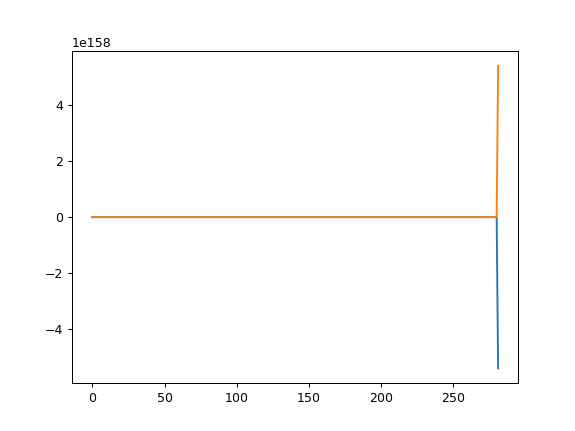

In [17]:
%matplotlib
plt.figure()
plt.plot(traj.predators.values[0:-500])
plt.plot(traj.preys.values[0:-500])

## pymofa again

suppose you want to increase the sample size:

In [18]:
SAMPLE_SIZE = 3

You can now re instanciate the experiment handle and compute the experiment all over agian. Expect that pymofa detacts that is has already computed something and wont to that again.

In [19]:
# initiate handle instance with experiment variables
handle = eh(RUN_FUNC,
            RUNFUNC_RESULTSFORM,
            PARAM_COMBS,
            SAMPLE_SIZE,
            SAVE_PATH_RAW)

initializing pymofa experiment handle
boooja
24 of 72 single computations left
detected 1 nodes in MPI environment


In [20]:
# Compute experiemnts raw data
handle.compute()

24 of 72 single computations left
Saving rawdata at /home/wbarfuss/Documents/Work/Software/pymofa/tutorial/dummy/pmX01data.h5
Only one node available. No parallel execution.
Calculating... 16.67%

/home/wbarfuss/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/wbarfuss/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/home/wbarfuss/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Calculating... 95.83%
Calculating... 100.00%
Calculattion done.


## Postprocessing or resaving
Supoose we want to  analyse our experiment data by computing some statistics on it. We can do is as well with pymofa.

Let's say that we are intersted in the sum of preys and predators in the first 250 time steps.

In [23]:
from pymofa.safehdfstore import SafeHDFStore

In [24]:
def eva(prey_birth_rate, predator_death_rate, initial_pop):
    query = "prey_birth_rate={} & ".format(prey_birth_rate) +\
        "predator_death_rate={} &".format(predator_death_rate) +\
        "initial_pop={} &".format(initial_pop) +\
        "tstep < 250"

    with SafeHDFStore(handle.path_raw) as store:
        traj = store.select("dat", where=query)
        
    samplesize = max(traj.index.get_level_values("sample").unique())

    res = pd.DataFrame({"preds": [traj.mean().predators / samplesize],
                        "preys": [traj.mean().preys / samplesize]})
    res.index.name = "value"
    
    return 42, res

eva_format = pd.DataFrame(columns=["preds", "preys"])
eva_format.index.name = "value"

prey_birth_rate = [0.09, 0.1, 0.11]
predator_death_rate = [0.005, 0.01, 0.05, 0.1]
initial_pop = [1.0, 2.0]
EVA_COMBS = list(it.product(prey_birth_rate, predator_death_rate, initial_pop))

resavehandle = eh(eva,
                  eva_format,
                  EVA_COMBS,
                  1,
                  "./AvgPop")

initializing pymofa experiment handle
24 of 24 single computations left
detected 1 nodes in MPI environment


In [25]:
resavehandle.compute()

24 of 24 single computations left
Saving rawdata at /home/wbarfuss/Documents/Work/Software/pymofa/tutorial/AvgPop.h5
Only one node available. No parallel execution.
Calculating... 95.83%
Calculating... 100.00%
Calculattion done.


### Observing the post  procecccced data

In [26]:
with pd.HDFStore(resavehandle.path_raw) as store:
    df = store.select("dat")

# cleaning
df.index = df.index.droplevel(level="sample").droplevel(level="value")

df = df.query("initial_pop == 1.0")
df.index = df.index.droplevel(level="initial_pop")

df = df.unstack()

df = df.loc[:, "preds"]
df

predator_death_rate,0.005,0.01,0.05,0.1
prey_birth_rate,,,,
0.09,0.880731,0.570644,0.493581,0.448053
0.10,0.903665,0.608098,0.531864,0.500585
0.11,0.981498,0.642836,0.567698,0.545875


In [27]:
from pymofa.experiment_visualization import explore_Parameterspace

<IPython.core.display.Javascript object>


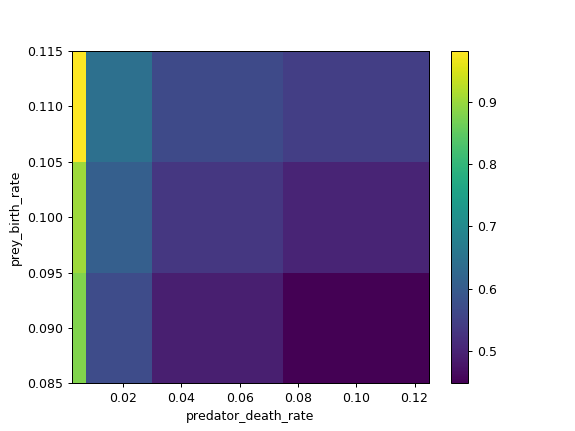

In [28]:
explore_Parameterspace(df)

... TA DA

## Closure

At the end we clean up:


In [29]:
!rm -r dummy/

In [30]:
!rm AvgPop.h5